In [1]:
import sys,os
import numpy as np
import networkx as nx
from shapely.geometry import LineString,Point,MultiLineString, LinearRing
from itertools import product
import matplotlib.pyplot as plt
from geographiclib.geodesic import Geodesic
import geopandas as gpd
from scipy.spatial import Voronoi
from itertools import combinations

workpath = os.getcwd()
figpath = workpath + "/figs/"
tmppath = workpath + "/temp/"

In [3]:
def draw_nodes(ax,graph,nodelist=None,color='red',size=30,alpha=1.0,marker='*'):
    if nodelist == None:
        nodelist = graph.nodes
    d = {'nodes':nodelist,
         'geometry':[Point(graph.nodes[n]['cord']) for n in nodelist]}
    df_nodes = gpd.GeoDataFrame(d, crs="EPSG:4326")
    df_nodes.plot(ax=ax,color=color,markersize=size,alpha=alpha,marker=marker)
    return ax

def draw_points(ax,points,color='red',size=10,alpha=1.0,marker='o'):
    if len(points) == 0:
        return ax
    if isinstance(points,list):
        d = {'nodes':range(len(points)),
             'geometry':[pt_geom for pt_geom in points]}
    elif isinstance(points,dict):
        d = {'nodes':range(len(points)),
             'geometry':[points[k] for k in points]}
    df_nodes = gpd.GeoDataFrame(d, crs="EPSG:4326")
    df_nodes.plot(ax=ax,color=color,markersize=size,alpha=alpha,marker=marker)
    return ax

def draw_edges(ax,graph,edgelist=None,color='red',width=2.0,style='solid',
               alpha=1.0):
    if edgelist == []:
        return ax
    if edgelist == None:
        edgelist = graph.edges
    d = {'edges':edgelist,
         'geometry':[graph.edges[e]['geometry'] for e in edgelist]}
    df_edges = gpd.GeoDataFrame(d, crs="EPSG:4326")
    df_edges.plot(ax=ax,edgecolor=color,linewidth=width,
                  linestyle=style,alpha=alpha)
    return ax

def draw_lines(ax,lines,color='red',width=2.0,style='solid',alpha=1.0):
    if isinstance(lines,LineString):
        lines = [lines]
    if len(lines) == 0:
        return ax
    d = {'edges':range(len(lines)),
         'geometry':[line_geom for line_geom in lines]}
    df_edges = gpd.GeoDataFrame(d, crs="EPSG:4326")
    df_edges.plot(ax=ax,edgecolor=color,linewidth=width,
                  linestyle=style,alpha=alpha)
    return ax

In [78]:
# interpolate points along each graph
def interpolate_points(lines,num_pts=100,ref='A'):
    points = {}
    for i,line_geom in enumerate(lines):
        dist = 1/num_pts
        start_ind = (i*num_pts)
        for f in range(num_pts+1):
            x,y = line_geom.interpolate(f*dist,normalized=True).xy
            xy = (x[0],y[0])
            points[ref+str(start_ind+f)] = Point(xy)
    return points

def get_cech_edge(pts,radius):
    edges = []
    for i,j in combinations(pts,2):
        buf_i = pts[i].buffer(radius)
        buf_j = pts[j].buffer(radius)
        if buf_i.intersects(buf_j):
            edges.append((i,j))
    return edges

def get_cech_triangle(pts,radius):
    triangles = []
    for i,j,k in combinations(pts,3):
        buf_i = pts[i].buffer(radius)
        buf_j = pts[j].buffer(radius)
        buf_k = pts[k].buffer(radius)
        if buf_i.intersection(buf_j).intersects(buf_k):
            triangles.append((i,j,k))
    return triangles
    

In [42]:
# Graph A
edges_A = [(1,2),(2,3)]
cords_A = {1:(-1,0.5), 2:(0,1), 3:(1,0.5)}
edge_geom_A = {e:LineString([cords_A[e[0]],cords_A[e[1]]]) for e in edges_A}

A = nx.Graph()
A.add_edges_from(edges_A)
nx.set_edge_attributes(A,edge_geom_A,'geometry')
nx.set_node_attributes(A,cords_A,'cord')
geom_A = [A.edges[e]['geometry'] for e in A.edges]

# Graph B
edges_B = [(11,12),(12,13),(13,14),(14,15)]
cords_B = {11:(-1,0.25), 12:(-0.5,0.75), 13:(0,1), 14:(0.5,0.6), 15:(1,0.5)}
edge_geom_B = {e:LineString([cords_B[e[0]],cords_B[e[1]]]) for e in edges_B}

B = nx.Graph()
B.add_edges_from(edges_B)
nx.set_edge_attributes(B,edge_geom_B,'geometry')
nx.set_node_attributes(B,cords_B,'cord')
geom_B = [B.edges[e]['geometry'] for e in B.edges]


pts_A = interpolate_points(geom_A,num_pts=10,ref='A')
pts_B = interpolate_points(geom_B,num_pts=10,ref='B')
pts = {}
for pt in pts_A:
    pts[pt] = pts_A[pt]
for pt in pts_B:
    pts[pt] = pts_B[pt]

In [79]:
for epsilon in range(10):
    rad = epsilon*0.1
    c_edges = get_cech_edge(pts,rad)
    c_triangles = get_cech_triangle(pts,rad)
    print(len(c_edges),len(c_triangles))


0 0
251 419
559 2429
827 5680
1078 10125
1297 15295
1510 21620
1671 27482
1780 32154
1852 35672


<AxesSubplot:>

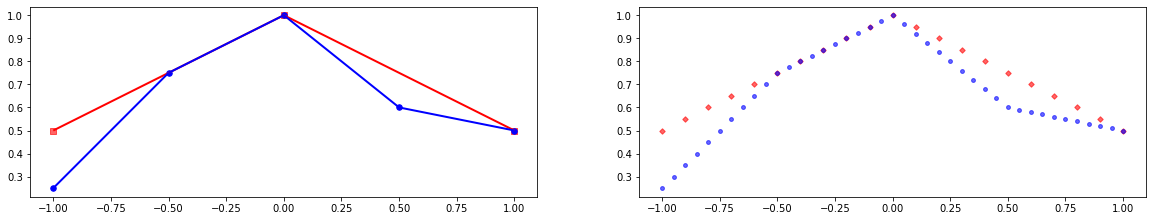

In [34]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)

draw_edges(ax1,A,color='red',width=2.0,style='solid')
draw_edges(ax1,B,color='blue',width=2.0,style='solid')
draw_nodes(ax1,A,color='red',size=30,marker='s',alpha=0.6)
draw_nodes(ax1,B,color='blue',size=30,marker='o')

ax2 = fig.add_subplot(1,2,2)
draw_points(ax2,pts_A,color='red',size=15,alpha=0.6,marker='D')
draw_points(ax2,pts_B,color='blue',size=15,alpha=0.6,marker='o')



In [2]:
def interpolate(line_geom,num_pts=100,ref='A'):
    points = {}
    dist = 1/num_pts
    for f in range(num_pts+1):
        x,y = line_geom.interpolate(f*dist,normalized=True).xy
        xy = (x[0],y[0])
        points[ref+str(f)] = Point(xy)
    return points

def get_arcs(seed,radius,geom):
    # Get number of points to be interpolated
    n_pts = 2*len(geom) + 1
    
    # Construct the linear ring and interpolate points
    lr = LinearRing(seed.buffer(radius).exterior.coords)
    pts = [lr.interpolate((i/n_pts),normalized=True) for i in range(n_pts+1)]
    
    # Construct the edgelist
    arc_geom = [LineString([pts[k],pts[k+1]]) for k in range(n_pts)]
    return arc_geom


In [4]:
#%% Skeletons
def intersect(geom_a,geom_b,eps):
    return geom_a.buffer(eps).intersects(geom_b.buffer(eps))

def intersection(geom_a,geom_b,eps=1e-4):
    return geom_a.buffer(eps).intersection(geom_b.buffer(eps)).boundary

def alter_slope(line,eps=1e-3):
    return LineString([Point(line.coords[0]),Point(line.coords[1][0],line.coords[1][1]+eps)])

def voronoi_bisector(line1,line2,num_pts=20):
    pts_A = interpolate(line1,num_pts,ref='A')
    pts_B = interpolate(line2,num_pts,ref='B')
    
    pA = np.array([(pts_A[k].x,pts_A[k].y) for k in pts_A])
    pB = np.array([(pts_B[k].x,pts_B[k].y) for k in pts_B])
    points = np.concatenate((pA,pB))
    
    try:
        vor = Voronoi(points)
    except:
        line2_alt = alter_slope(line2,eps=1e-3)
        pts_B = interpolate(line2_alt,num_pts,ref='B')
        pB = np.array([(pts_B[k].x,pts_B[k].y) for k in pts_B])
        points = np.concatenate((pA,pB))
        vor = Voronoi(points)
        
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices \
             if -1 not in line]
    return MultiLineString(lines)

def voronoi_ridge(line1,line2,line3,num_pts=20):
    pts_A = interpolate(line1,num_pts,ref='A')
    pts_B = interpolate(line2,num_pts,ref='B')
    pts_C = interpolate(line3,num_pts,ref='C')
    
    pA = np.array([(pts_A[k].x,pts_A[k].y) for k in pts_A])
    pB = np.array([(pts_B[k].x,pts_B[k].y) for k in pts_B])
    pC = np.array([(pts_C[k].x,pts_C[k].y) for k in pts_C])
    points = np.concatenate((pA,pB,pC))
    
    vor = Voronoi(points)
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices \
             if -1 not in line]
    return MultiLineString(lines)

def one_skeleton(geom):
    return {(i,j):geom[i].distance(geom[j]) for i in range(len(geom)) \
            for j in range(len(geom))}

def two_skeleton(geom):
    for i in range(len(geom)):
        for j in range(len(geom)):
            if i==j:
                b_ij = geom[i]
            else:
                b_ij = voronoi_bisector(geom[i],geom[j])
    

C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:39: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(lines) == 0:
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:41: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  d = {'edges':range(len(lines)),
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  'geometry':[line_geom for line_geom in lines]}


<AxesSubplot:>

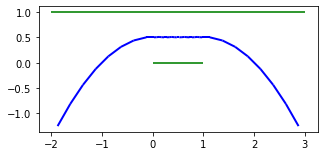

In [5]:
edge1 = LineString([Point(0,0),Point(1,0)])
edge2 = LineString([Point(-2,1),Point(3,1)])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
draw_lines(ax,[edge1,edge2],color='green',alpha=0.8)

bisector = voronoi_bisector(edge1, edge2)
draw_lines(ax, bisector, color='blue')


C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:39: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(lines) == 0:
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:41: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  d = {'edges':range(len(lines)),
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  'geometry':[line_geom for line_geom in lines]}


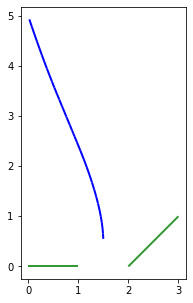

In [6]:
edge1 = LineString([Point(0,0),Point(1,0)])
edge2 = LineString([Point(2,0),Point(3,1)])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
draw_lines(ax,[edge1,edge2],color='green',alpha=0.8)

bisector = voronoi_bisector(edge1, edge2)
ax = draw_lines(ax, bisector, color='blue')

C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:39: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(lines) == 0:
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:41: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  d = {'edges':range(len(lines)),
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  'geometry':[line_geom for line_geom in lines]}


<AxesSubplot:>

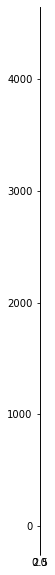

In [7]:
edge1 = LineString([Point(0,0),Point(1,0)])
edge2 = LineString([Point(2,0),Point(3,0)])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
draw_lines(ax,[edge1,edge2],color='green',alpha=0.8)

bisector = voronoi_bisector(edge1, edge2)
draw_lines(ax, bisector, color='blue')

C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:39: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(lines) == 0:
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:41: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  d = {'edges':range(len(lines)),
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  'geometry':[line_geom for line_geom in lines]}
C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\419573778.py:39: Sh

(0.0, 10.0)

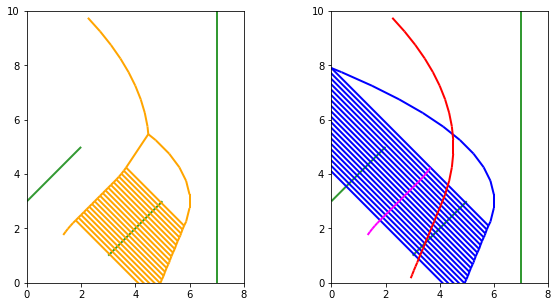

In [8]:
edge1 = LineString([Point(3,1),Point(5,3)])
edge2 = LineString([Point(0,3),Point(2,5)])
edge3 = LineString([Point(7,0),Point(7,10)])

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
draw_lines(ax,[edge1,edge2,edge3],color='green',alpha=0.8)

bisector = voronoi_ridge(edge1,edge2,edge3)
draw_lines(ax, bisector, color='orange')
ax.set_xlim(0,8)
ax.set_ylim(0,10)

ax = fig.add_subplot(1,2,2)
draw_lines(ax,[edge1,edge2,edge3],color='green',alpha=0.8)


bisector_1 = voronoi_bisector(edge1, edge3)
bisector_2 = voronoi_bisector(edge1, edge2)
bisector_3 = voronoi_bisector(edge2, edge3)
draw_lines(ax, bisector_1, color='blue')
draw_lines(ax, bisector_2, color='magenta')
draw_lines(ax, bisector_3, color='red')
ax.set_xlim(0,8)
ax.set_ylim(0,10)

In [9]:
print(bisector[0])

LINESTRING (3.299999999999997 3.799999999999997, 5.564285714285714 1.535714285714289)


C:\Users\rm5nz\AppData\Local\Temp\ipykernel_15472\1823718050.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  print(bisector[0])


In [ ]:
# Graph A
edges_A = [(1,2),(2,9),(9,10),(10,3),(3,4),(2,5),(2,6),(3,7),(3,8)]
cords_A = {1:(-2,0.125), 2:(-1.125,0.125), 5:(-1.125,1.025), 6:(-1.125,-1),
           3:(1.125,-0.125), 4:(2,-0.125), 7:(1.125,1.025), 8:(1.125,-1),
           9:(0,0.125), 10:(0,-0.125)}
edge_geom_A = {e:LineString([cords_A[e[0]],cords_A[e[1]]]) for e in edges_A}

A = nx.Graph()
A.add_edges_from(edges_A)
nx.set_edge_attributes(A,edge_geom_A,'geometry')
nx.set_node_attributes(A,cords_A,'cord')
geom_A = [A.edges[e]['geometry'] for e in A.edges]

# Graph B
edges_B = [(11,12),(12,13),(13,14),(12,15),(12,16),(13,17),(13,18)]
cords_B = {11:(-2,0), 12:(-1,0), 15:(-1,1), 16:(-1,-1),
           13:(1,0), 14:(2,0), 17:(1,1), 18:(1,-1)}
edge_geom_B = {e:LineString([cords_B[e[0]],cords_B[e[1]]]) for e in edges_B}

B = nx.Graph()
B.add_edges_from(edges_B)
nx.set_edge_attributes(B,edge_geom_B,'geometry')
nx.set_node_attributes(B,cords_B,'cord')
geom_B = [B.edges[e]['geometry'] for e in B.edges]